<a href="https://colab.research.google.com/github/prrmzz/Mask-Detection/blob/main/FaceMaskDetection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
data_path = '/content/drive/My Drive/FaceMaskDetection.ds/'
annotations_path = os.path.join(data_path, 'annotations')
images_path = os.path.join(data_path, 'images')
cropped_dataset_path = '/content/face_mask_cropped/'

In [ ]:
os.makedirs(os.path.join(cropped_dataset_path, 'with_mask'), exist_ok=True)
os.makedirs(os.path.join(cropped_dataset_path, 'without_mask'), exist_ok=True)

In [ ]:
for xml_file in os.listdir(annotations_path):
    if xml_file.endswith('.xml'):
        tree = ET.parse(os.path.join(annotations_path, xml_file))
        root = tree.getroot()

        filename = root.find('filename').text
        image_path = os.path.join(images_path, filename)

        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {image_path}")
            continue

        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')

            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            cropped_image = image.crop((xmin, ymin, xmax, ymax))
            label = 'with_mask' if name == 'mask' else 'without_mask'
            save_path = os.path.join(cropped_dataset_path, label, f"{filename.split('.')[0]}_{xmin}_{ymin}.jpg")
            cropped_image.save(save_path, format='JPEG')

print("Cropped dataset created at:", cropped_dataset_path)

Cropped dataset created at: /content/face_mask_cropped/


In [ ]:
data_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.4,
    fill_mode='nearest',
    validation_split=0.2
)

train = data_generator.flow_from_directory(cropped_dataset_path,
                                           class_mode='binary',
                                           batch_size=32,
                                           target_size=(224, 224),
                                           subset='training')

validation = data_generator.flow_from_directory(cropped_dataset_path,
                                                class_mode='binary',
                                                batch_size=32,
                                                target_size=(224, 224),
                                                subset='validation')

Found 3258 images belonging to 2 classes.
Found 814 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
history = model.fit(train,
                    steps_per_epoch=len(train),
                    validation_data=validation,
                    validation_steps=len(validation),
                    epochs=50,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1807s 18s/step - accuracy: 0.5133 - loss: 0.9840 - val_accuracy: 1.0000 - val_loss: 2.9697e-04 - learning_rate: 1.0000e-04
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1808s 18s/step - accuracy: 0.5684 - loss: 0.8084 - val_accuracy: 1.0000 - val_loss: 0.0363 - learning_rate: 1.0000e-04
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1810s 18s/step - accuracy: 0.6127 - loss: 0.7220 - val_accuracy: 0.3120 - val_loss: 2.3574 - learning_rate: 1.0000e-04
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1804s 18s/step - accuracy: 0.6603 - loss: 0.6485 - val_accuracy: 0.4509 - val_loss: 3.1287 - learning_rate: 1.0000e-04
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1775s 17s/step - accuracy: 0.7043 - loss: 0.5800 - val_accuracy: 0.8231 - val_loss: 0.8280 - learning_rate: 1.0000e-04
Ep

In [ ]:
model.save('face_mask_detection.h5')

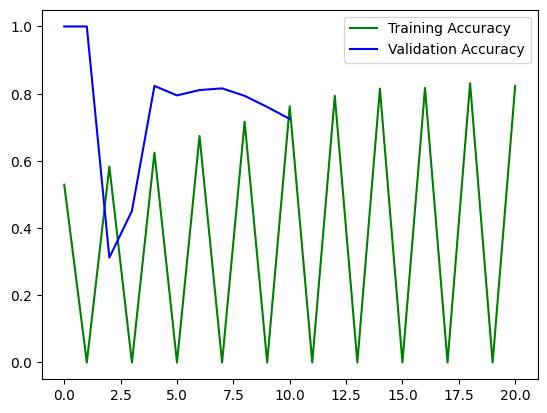

In [ ]:
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.legend()
plt.show()